In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from neuron import h
from bmtool.singlecell import Profiler, Passive, CurrentClamp, FI, ZAP

template_dir = '../Network-Parameters/components/templates'
mechanism_dir = '../Network-Parameters/components/mechanisms'

profiler = Profiler(template_dir=template_dir, mechanism_dir=mechanism_dir, dt = 0.05)

def run_and_plot(sim, title, xlabel, ylabel, plot=True, plot_injection_only=False):
    X, Y = sim.execute()
    X = np.array(X)
    Y = np.array(Y)
    if plot:
        plt.figure()
        if plot_injection_only:
            t_idx = (X >= sim.inj_delay) & (X <= sim.inj_delay + sim.inj_dur)
            plt.plot(X[t_idx], Y[t_idx])
        else:
            plt.plot(X, Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    return X, Y

In [2]:
noise = False
post_init_function = 'insert_mechs(0)' if noise else None

# CP cell settings
basic_settings = {
    'Passive': {
        'celsius': 26.,
        'kwargs': {
            'inj_amp': -100.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 2500.,
            'method': 'exp2'
        }
    },
    'CurrentClamp': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 350.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 3000.,
            'threshold': 0.
        }
    },
    'ZAP': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 100.,
            'inj_delay': 1000.,
            'inj_dur': 15000.,
            'tstop': 15500.,
            'fstart': 0.,
            'fend': 15.,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'i_start': 0.,
            'i_stop': 1000.,
            'i_increment': 50.,
            'tstart': 1500.
        }
    }
}
Cell_settings = {cell: deepcopy(basic_settings) for cell in ['CP_Cell', 'CS_Cell', 'FSI_Cell', 'LTS_Cell']}

Cell_settings['CP_Cell']['ZAP'] = None

# CS cell settings
settings = Cell_settings['CS_Cell']
settings['CurrentClamp']['kwargs']['inj_amp'] = 300.

# FSI cell settings
settings = Cell_settings['FSI_Cell']
settings['Passive']['celsius'] = 30.
settings['Passive']['kwargs'] = {'inj_amp': -100., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'method': 'exp2'}
settings['CurrentClamp']['celsius'] = 21.
settings['CurrentClamp']['kwargs'] = {'inj_amp': 200., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'threshold': 0.}
settings['ZAP']['celsius'] = 30.
settings['ZAP']['kwargs']['inj_amp'] = 10.
settings['FI']['celsius'] = 30.
settings['FI']['kwargs']['tstart'] = 500.
# settings['Passive'] = None
#settings['ZAP'] = None
#settings['FI'] = None

# LTS cell settings
settings = Cell_settings['LTS_Cell'] = deepcopy(Cell_settings['FSI_Cell'])
settings['CurrentClamp']['kwargs']['inj_amp'] = 50. 

In [3]:
Cell = 'CP_Cell'
settings = Cell_settings[Cell]

# Ranges for each Type of Cell
## Currently for L2/3 model the plan is to only have one excitatory cell currently using CP cell template
| Cell | Apical Len(um)  | V_rest(mV) | R_in(Mohms)  | Tau_m(ms)   | FI Curve Threshold(pA) | FI Curve Slope(Hz/nA) |
|:-----|:----------------|:---------|:-------------|:------------|:-----------------------|:-------------------------|
| PN   | 323 ± 244       | -76 ± 5  | 89.0 ± 21.9  | 20.1 ± 5.7  | 263 ± 65               | 0.02 (from median ISI 50.9)|
| FSI  | ?               |  ?       | 145 ± 24.1    |     ?  |   ?            |  ?  | ?
| LTS  | ?               | -65 ± 0.63  | 449 ± 30  | ?           | 38.5 ± 6               | ?                        |

* ### PN data from Hirai et al 2012 with length from Lederberger and Larkum 2010
* ### FSI data from Carl et al 2003
* ### LTS data from Fino el al 2011

##### tuning notes
##### The Carl et al 2003 paper has PN R_in around 197 ± 38.5 this higher input resistance would help get Tau_m to be lower which could be important

#### Passive Properties

In [4]:
proc = settings['Passive']
if proc is not None:
    h.celsius = proc['celsius']
    sim = Passive(Cell, **proc['kwargs'])
    title = 'Passive Cell Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[0].soma[0](0.5)
Recording: CP_Cell[0].soma[0](0.5)._ref_v


Running simulation for passive properties...

V Rest: -75.89 (mV)
Resistance: 106.25 (MOhms)
Membrane time constant: 28.70 (ms)

V_rest Calculation: Voltage taken at time 1500.0 (ms) is
-75.89 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-86.51 - (-75.89)) / (-0.1 - 0)
10.62 (mV) / 0.1 (nA) = 106.25 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-86.49, -39.20, 49.80, 28.70, 22.09)
Membrane time constant is determined from the slowest exponential term: 28.70 (ms)

Sag potential: v_sag = v_peak - v_final = -1.67 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = 0.136



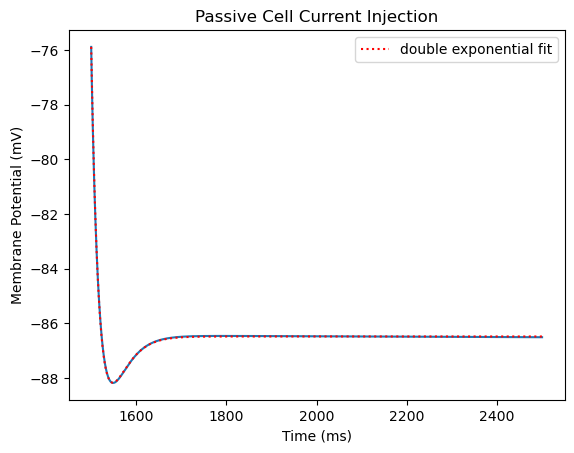

In [5]:
if proc is not None:
    if sim.method == 'exp2':
        X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
        plt.gca().plot(*sim.double_exponential_fit(), 'r:', label='double exponential fit')
        plt.legend()
    else:
        X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Current Injection

In [6]:
proc = settings['CurrentClamp']
if proc is not None:
    h.celsius = proc['celsius']
    sim2 = CurrentClamp(Cell, **proc['kwargs'])
    title = 'Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[1].soma[0](0.5)
Recording: CP_Cell[1].soma[0](0.5)._ref_v


Current clamp simulation running...

Number of spikes: 29



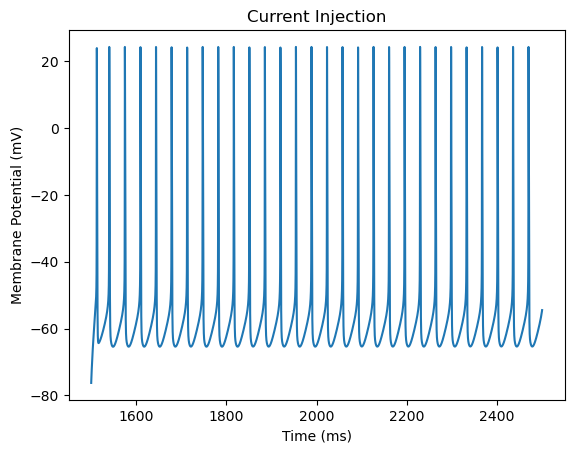

In [7]:
if proc is not None:
    X, Y = run_and_plot(sim2, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Impedance Amplitude Profile (ZAP)

In [8]:
proc = settings['ZAP']
if proc is not None:
    h.celsius = proc['celsius']
    sim3 = ZAP(Cell, **proc['kwargs'])
    title = 'ZAP Response'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

In [9]:
if proc is not None:
    X, Y = run_and_plot(sim3, title, xlabel, ylabel, plot_injection_only=True)

    plt.figure()
    plt.plot(X, sim3.zap_vec)
    plt.title('ZAP Current')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current Injection (nA)')

    plt.figure()
    plt.plot(*sim3.get_impedance(smooth=9))
    plt.title('Impedance Amplitude Profile')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (MOhms)')
    plt.show()

#### F-I Curve

In [10]:
proc = settings['FI']
if proc is not None:
    h.celsius = proc['celsius']
    sim4 = FI(Cell, **proc['kwargs'])
    title = 'FI Curve'
    xlabel = 'Injection (nA)'
    ylabel = '# Spikes'

Injection location: CP_Cell[21].soma[0](0.5)
Recording: CP_Cell[21].soma[0](0.5)._ref_v


Running simulations for FI curve...

Results
Injection (nA): 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95
Number of spikes: 0, 0, 0, 2, 14, 19, 24, 29, 35, 40, 45, 50, 55, 61, 67, 73, 80, 5, 4, 3



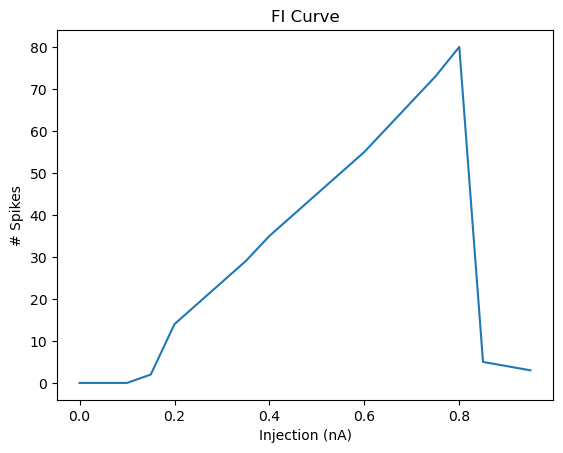

In [11]:
if proc is not None:
    X, Y = run_and_plot(sim4, title, xlabel, ylabel)
    plt.show()

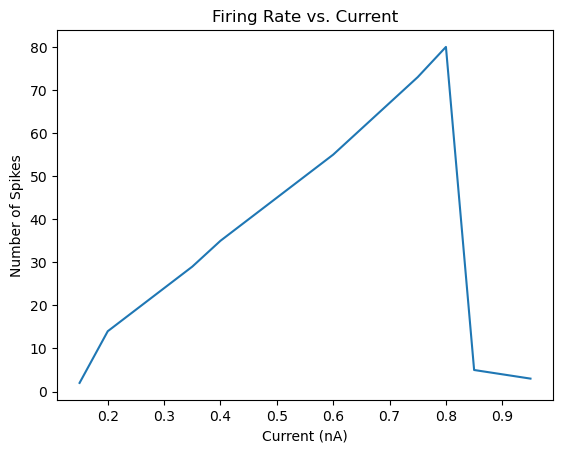

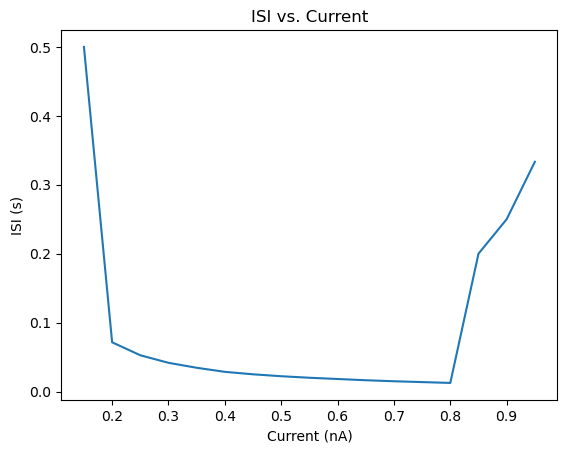

In [12]:
import numpy as np
from scipy.stats import linregress

zero_indices = np.where(Y == 0)[0]
filtered_X = np.delete(X, zero_indices)
filtered_Y = np.delete(Y, zero_indices)

# Calculate interspike interval (ISI) from firing rate
ISI = 1 / filtered_Y


# Plotting the data and fitted line (optional)
import matplotlib.pyplot as plt

plt.plot(filtered_X, filtered_Y)
plt.xlabel('Current (nA)')
plt.ylabel('Number of Spikes')
plt.title('Firing Rate vs. Current')

plt.figure()
plt.plot(filtered_X, ISI)
plt.xlabel('Current (nA)')
plt.ylabel('ISI (s)')
plt.title('ISI vs. Current')
plt.show()
